In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU, use CPU
# gpus = tf.config.experimental.list_physical_devices("GPU")
# if gpus:
#     try:
#         tf.config.experimental.set_memory_growth(gpus[0], True)
#         print("✅ GPU Acceleration Enabled")
#     except RuntimeError as e:
#         print(e)
tf.config.set_visible_devices([], 'GPU')

In [2]:
################### Split train - test ###################

image_dir = "/Users/rfalcao/Documents/FYP/ManualSegmentationAnns/cusp_images"
mask_dir = "/Users/rfalcao/Documents/FYP/ManualSegmentationAnns/masks"

import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

IMG_SIZE = 224  # Input size for U-Net

# Get all image filenames
image_filenames = sorted(os.listdir(image_dir))  # Sort for consistency
mask_filenames = set(os.listdir(mask_dir))  # Convert to set for fast lookup


# Split filenames into train (80%) and unseen test set (20%)
train_filenames, test_filenames = train_test_split(image_filenames, test_size=0.2, random_state=42)

print(f"Training Set: {len(train_filenames)} images")
print(f"Unseen Test Set: {len(test_filenames)} images")


Training Set: 161 images
Unseen Test Set: 41 images


In [3]:
################### Augment data ###################

datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

def augment_images(filenames, image_dir, mask_dir, num_augments_per_image=4):
    images, masks = [], []

    for filename in filenames:
        img_path = os.path.join(image_dir, filename)

        # ✅ Convert .jpg filename to .png for mask lookup
        mask_filename = os.path.splitext(filename)[0] + ".png"
        mask_path = os.path.join(mask_dir, mask_filename) if mask_filename in mask_filenames else None

        # Load image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Skipping {filename} (missing image)")
            continue

        # Normalize
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=-1)

        # Load mask or create an empty one
        if mask_path and os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = mask.astype(np.float32) / 255.0
            mask = np.expand_dims(mask, axis=-1)
        else:
            mask = np.zeros((img.shape[0], img.shape[1], 1), dtype=np.float32)

        # Apply augmentation multiple times
        for _ in range(num_augments_per_image):
            seed = np.random.randint(10000)
            aug_img = datagen.random_transform(img, seed=seed)
            aug_mask = datagen.random_transform(mask, seed=seed)

            # Resize after augmentation
            aug_img = cv2.resize(aug_img, (IMG_SIZE, IMG_SIZE))
            aug_mask = cv2.resize(aug_mask, (IMG_SIZE, IMG_SIZE))

            images.append(aug_img)
            masks.append(aug_mask)

    return np.array(images), np.array(masks)

# Load and augment only training images
augmented_X_train, augmented_y_train = augment_images(train_filenames, image_dir, mask_dir, num_augments_per_image=5)

print(f"Total Training Images After Augmentation: {len(augmented_X_train)}")
print(f"Total Training Masks After Augmentation: {len(augmented_y_train)}")

Total Training Images After Augmentation: 805
Total Training Masks After Augmentation: 805


In [14]:
################### Define Model ###################

NUM_CLASSES = 1
IMG_SIZE = 224  # Input size for U-Net
from metrics import weighted_loss , dice_coef, iou 
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# 🔥 Exponential decay: Start high, decrease over time
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-4,  # 🔹 Start with a higher LR
    decay_steps=5000,  # 🔹 Reduce LR every 5000 steps
    decay_rate=0.9,  # 🔹 Each step, LR = LR * decay_rate (0.9)
    staircase=True  # 🔹 Change LR in discrete steps
)

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def unet_model(input_size=(IMG_SIZE, IMG_SIZE, 1)):
    inputs = Input(input_size)

    # Contracting path (Encoder)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)

    # Bottleneck (Deepest part)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)

    # Expansive path (Decoder)
    up1 = UpSampling2D((2, 2))(conv4)
    concat1 = Concatenate()([up1, conv3])
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat1)

    up2 = UpSampling2D((2, 2))(conv5)
    concat2 = Concatenate()([up2, conv2])
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat2)

    up3 = UpSampling2D((2, 2))(conv6)
    concat3 = Concatenate()([up3, conv1])
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat3)

    # Final segmentation map
    output = Conv2D(NUM_CLASSES, (1, 1), activation='tanh')(conv7)  

    # Compile Model
    model = Model(inputs, output)
    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss=weighted_loss,
        metrics=['binary_accuracy', dice_coef, iou]
    )

    return model


# Create and train model
model = unet_model()
model.summary()




Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 224, 224,  │        640 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 112, 112,  │          0 │ conv2d_40[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 112, 112,  │     73,856 │ max_pooling2d_15… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 56, 56,    │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 56, 56,    │    295,168 │ max_pooling2d_16… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 28, 28,    │          0 │ conv2d_42[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 28, 28,    │  1,180,160 │ max_pooling2d_17… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_15    │ (None, 56, 56,    │          0 │ conv2d_43[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 56, 56,    │          0 │ up_sampling2d_15… │
│ (Concatenate)       │ 768)              │            │ conv2d_42[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 56, 56,    │  1,769,728 │ concatenate_15[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_16    │ (None, 112, 112,  │          0 │ conv2d_44[0][0]   │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 112, 112,  │          0 │ up_sampling2d_16… │
│ (Concatenate)       │ 384)              │            │ conv2d_41[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 112, 112,  │    442,496 │ concatenate_16[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_17    │ (None, 224, 224,  │          0 │ conv2d_45[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_17      │ (None, 224, 224,  │          0 │ up_sampling2d_17… │
│ (Concatenate)       │ 192)              │            │ conv2d_40[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 224, 224,  │    110,656 │ concatenate_17[0

 Total params: 3,872,769 (14.77 MB)

 Trainable params: 3,872,769 (14.77 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
################### Check for blank masks ###################

print("Checking dataset for blank masks...")
num_blank_masks = np.sum(np.all(augmented_y_train == 0, axis=(1,2)))  # Count fully blank masks
print(f"⚠️ Found {num_blank_masks} blank masks out of {len(augmented_y_train)} total.")

if num_blank_masks > 0:
    print(f"❌ Your dataset contains {num_blank_masks} fully blank masks! Consider removing or handling them.")


Checking dataset for blank masks...
⚠️ Found 9 blank masks out of 805 total.
❌ Your dataset contains 9 fully blank masks! Consider removing or handling them.


In [16]:
################### Train model ###################
from tensorflow.keras.callbacks import ReduceLROnPlateau

# 🔥 Reduce LR when validation loss stops improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
)
from tensorflow.keras.callbacks import EarlyStopping

# mixed_precision.set_global_policy('mixed_float16')
# ✅ Use Early Stopping for efficient training
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# ✅ Train the model
history = model.fit(
    augmented_X_train, augmented_y_train,
    epochs=50,  
    batch_size=8,  # Increase batch size for better GPU utilization
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 437s 5s/step - binary_accuracy: 0.6853 - dice_coef: 0.2472 - iou: 0.0658 - loss: 0.7328 - val_binary_accuracy: 0.7547 - val_dice_coef: 0.4138 - val_iou: 0.4635 - val_loss: 0.5789
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 447s 6s/step - binary_accuracy: 0.7589 - dice_coef: 0.4495 - iou: 0.4968 - loss: 0.5520 - val_binary_accuracy: 0.7452 - val_dice_coef: 0.4320 - val_iou: 0.4792 - val_loss: 0.5671
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 434s 5s/step - binary_accuracy: 0.7499 - dice_coef: 0.4801 - iou: 0.4954 - loss: 0.5236 - val_binary_accuracy: 0.7801 - val_dice_coef: 0.4593 - val_iou: 0.4252 - val_loss: 0.5151
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 433s 5s/step - binary_accuracy: 0.7780 - dice_coef: 0.5172 - iou: 0.4789 - loss: 0.4770 - val_binary_accuracy: 0.7802 - val_dice_coef: 0.5335 - val_iou: 0.4479 - val_loss: 0.4665
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 373s 5s/step - binary_accuracy: 0.7710 - dice_coef: 0.5980 - iou: 0.5040 - loss: 0.4311 - val_

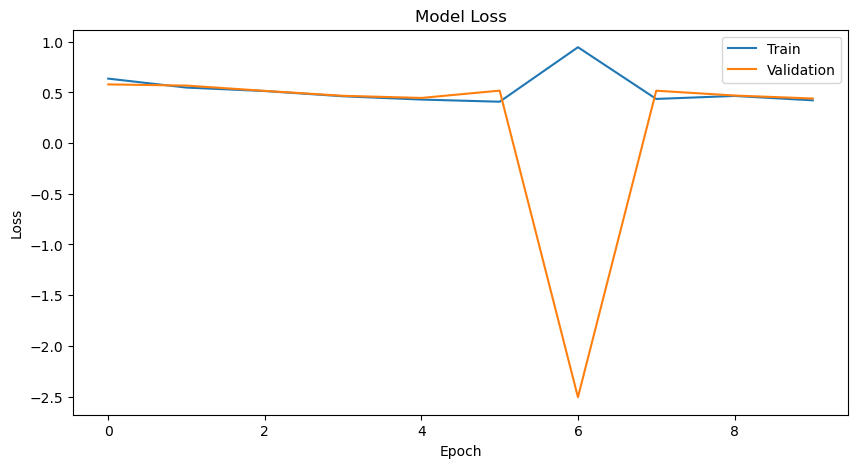

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
model.save('Unetlong2.h5')

In [19]:
# Extract X_test and y_test from test_filenames
def load_test_images(filenames, image_dir, mask_dir):
    images, masks = [], []

    for filename in filenames:
        img_path = os.path.join(image_dir, filename)
        
        # ✅ Convert .jpg filename to .png for mask lookup
        mask_filename = os.path.splitext(filename)[0] + ".png"
        mask_path = os.path.join(mask_dir, mask_filename) if mask_filename in mask_filenames else None

        # Load image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Skipping {filename} (missing image)")
            continue

        # Resize image
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=-1)

        # Load mask or create an empty one
        if mask_path and os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
            mask = mask.astype(np.float32) / 255.0
            mask = np.expand_dims(mask, axis=-1)
        else:
            mask = np.zeros((IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load test images (no augmentation)
X_test, y_test = load_test_images(test_filenames, image_dir, mask_dir)

print(f"Final Test Set Size: {len(X_test)} images")

Final Test Set Size: 41 images


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


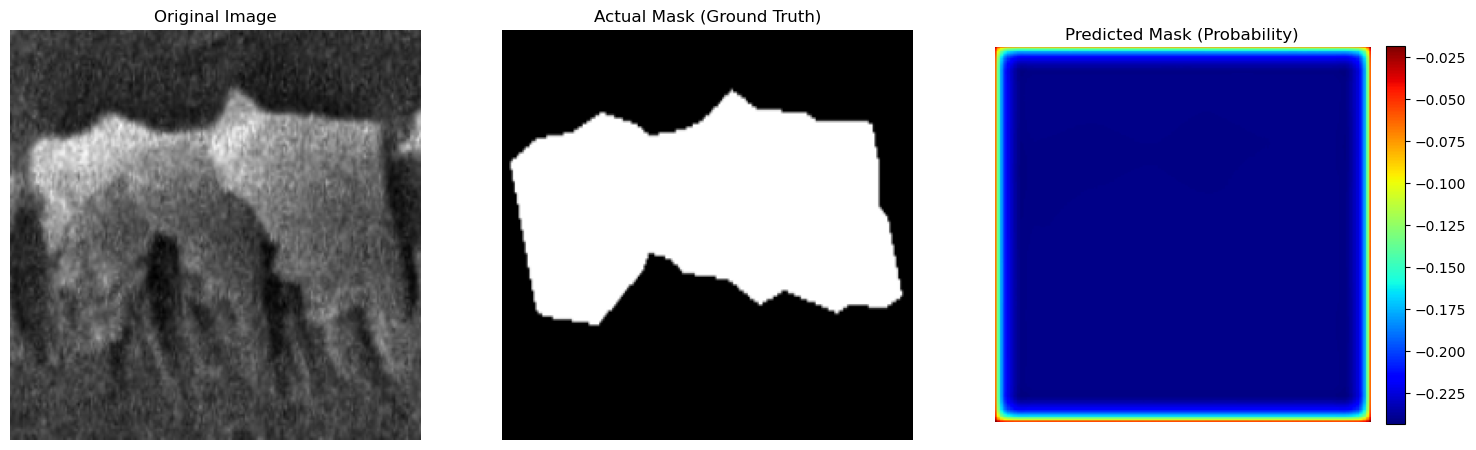

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


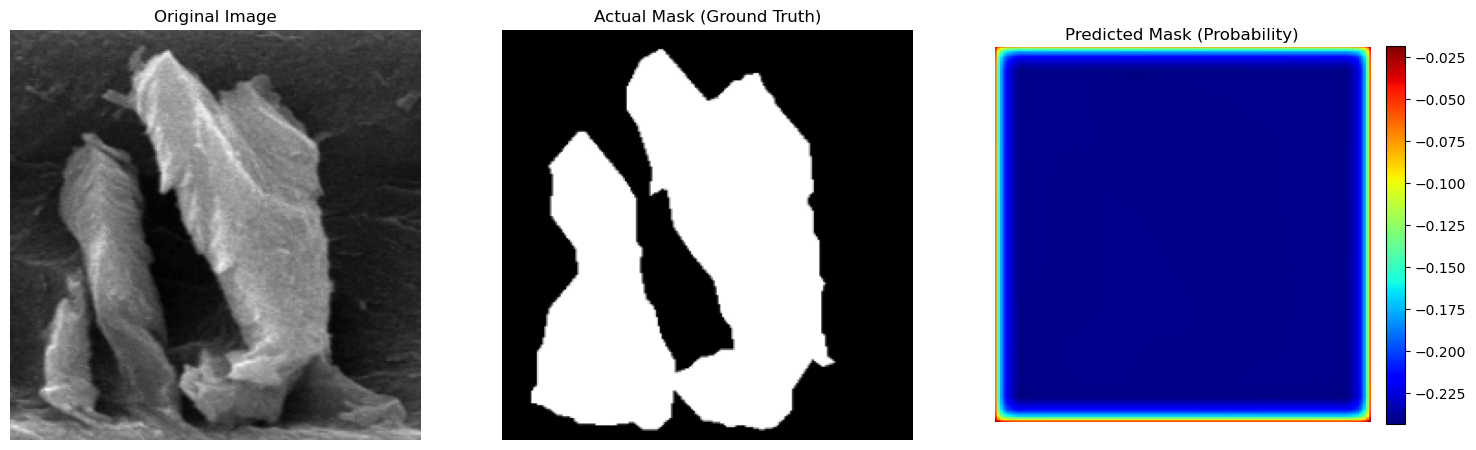

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


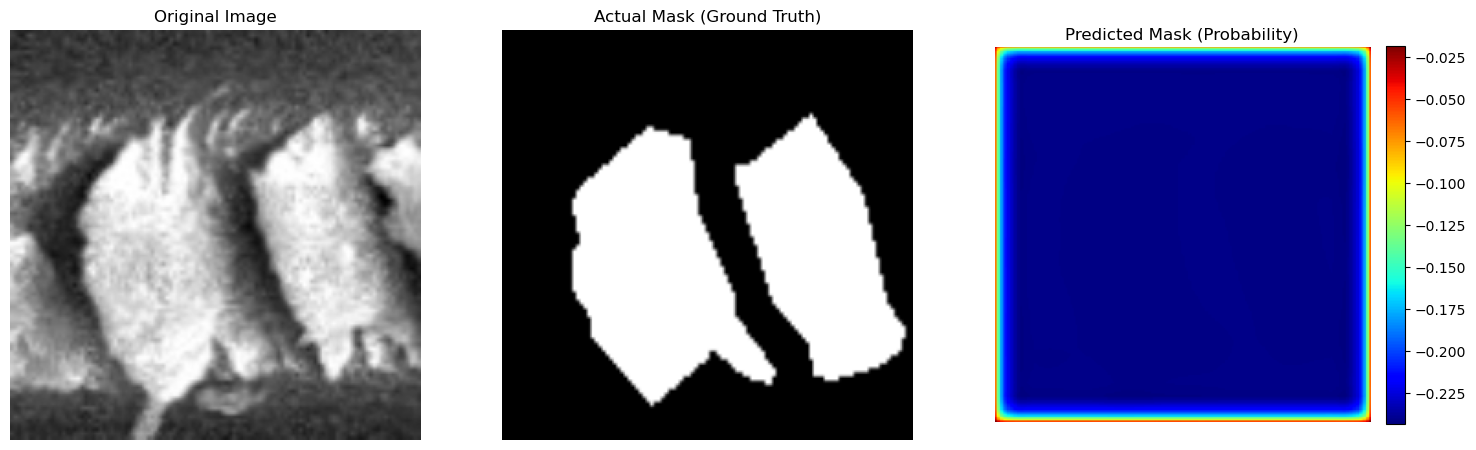

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


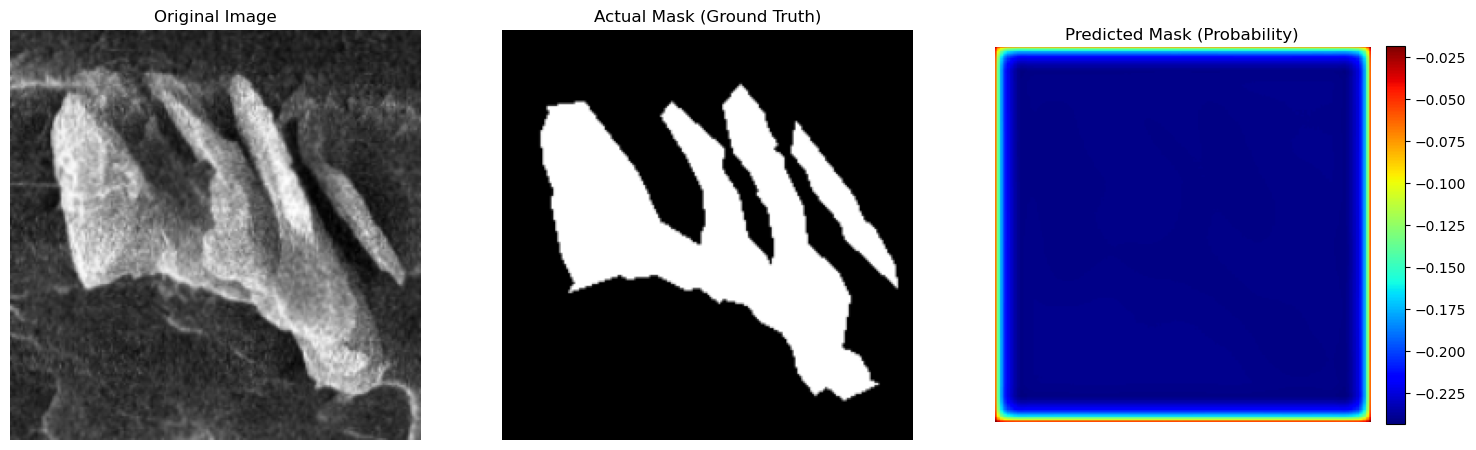

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


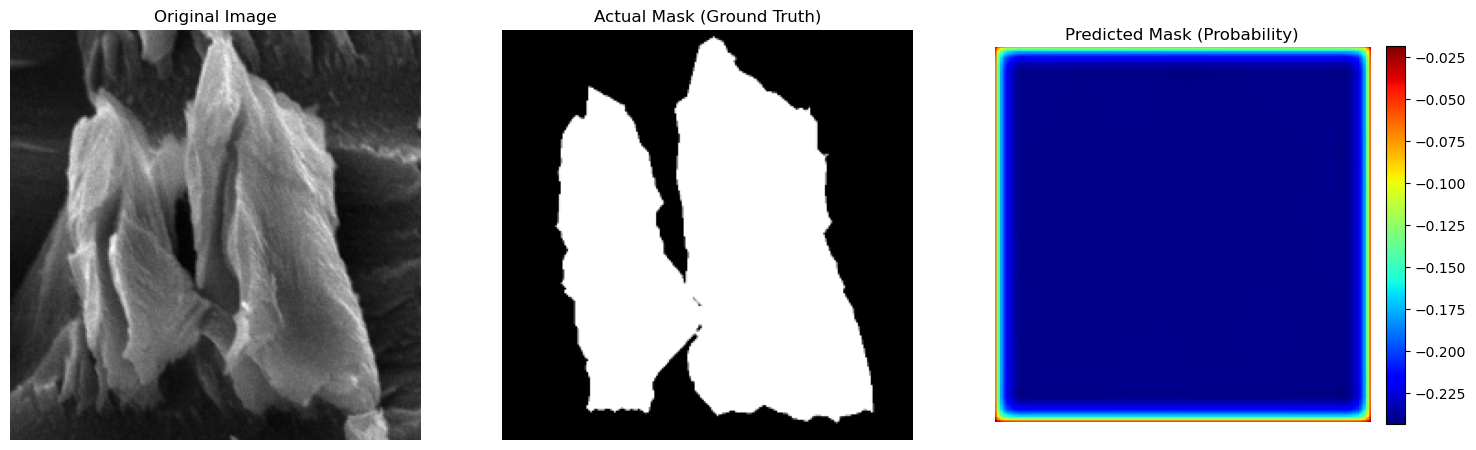

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


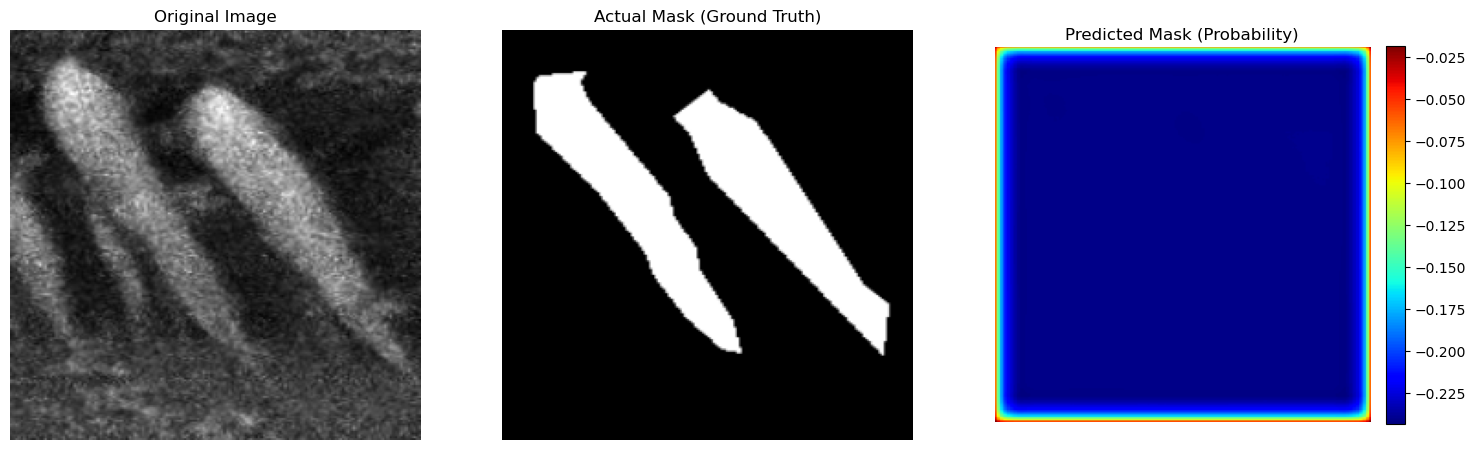

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


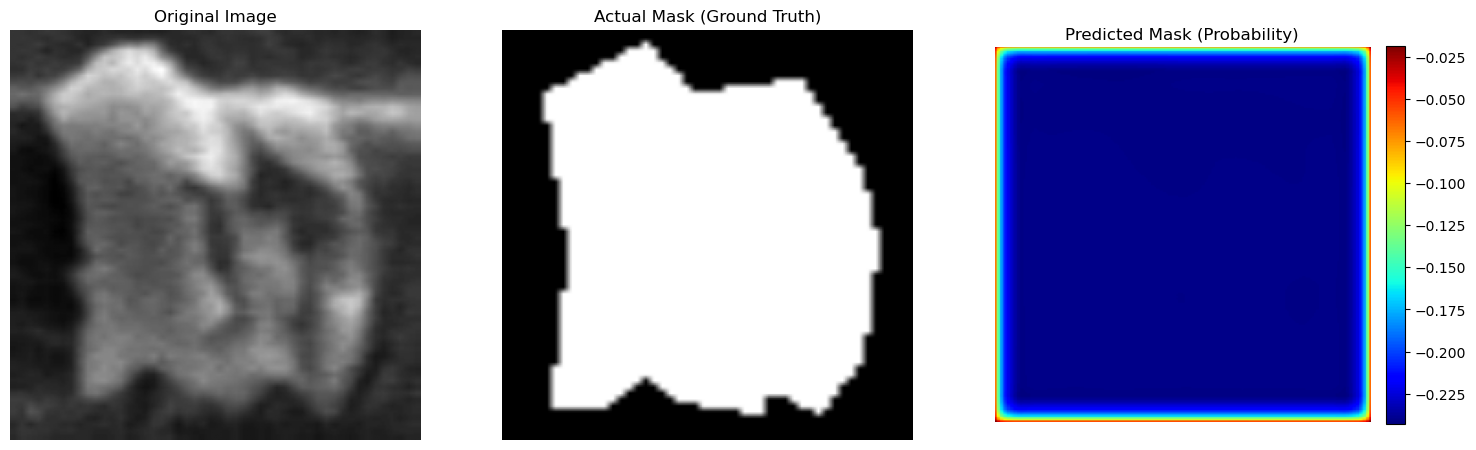

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


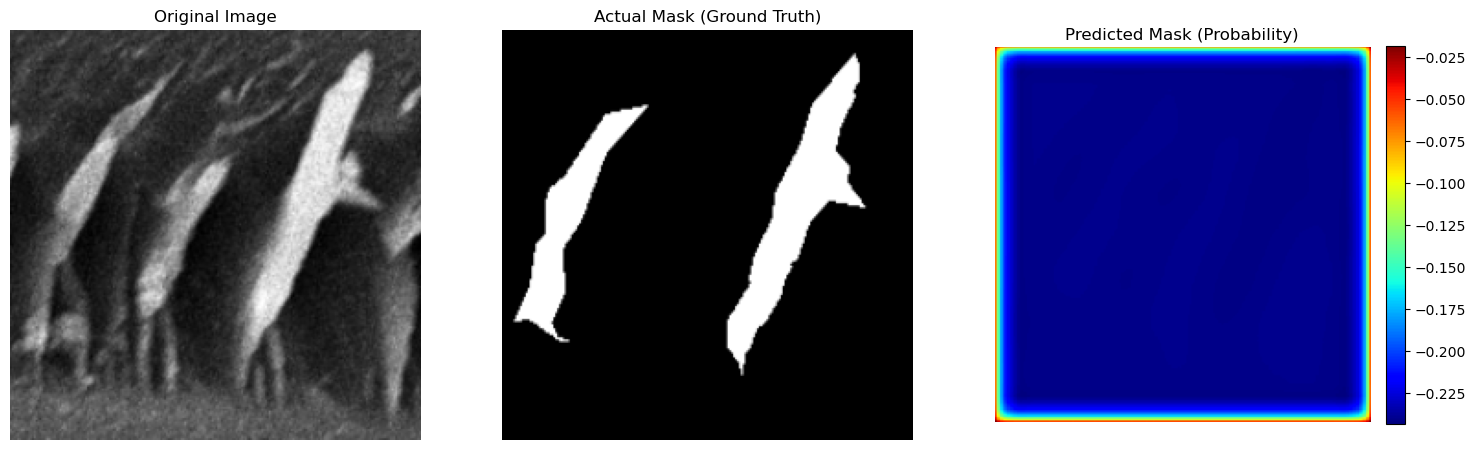

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


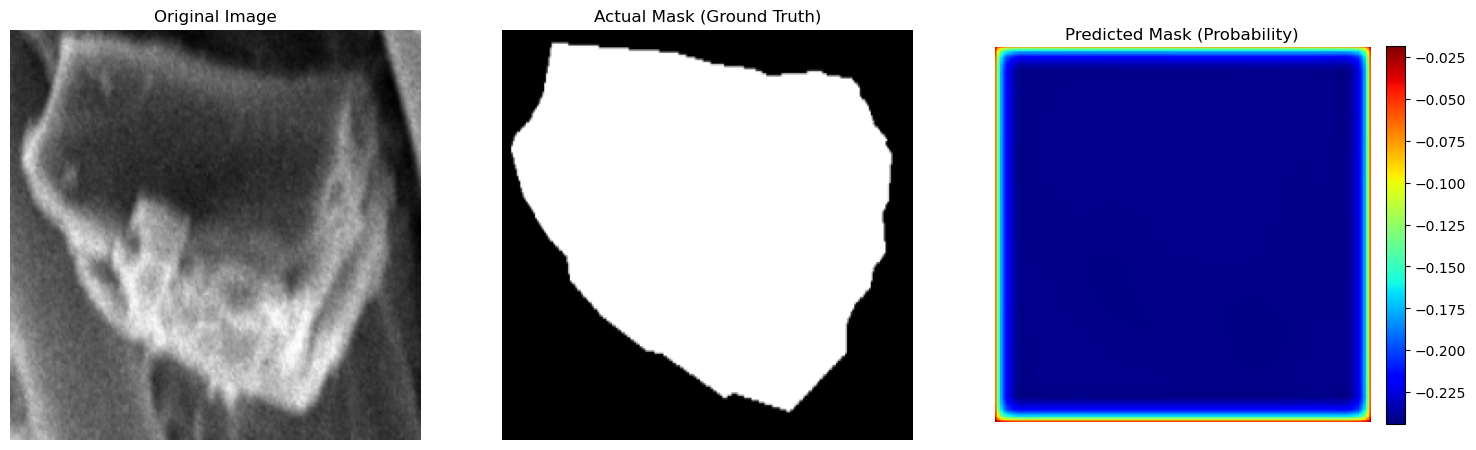

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


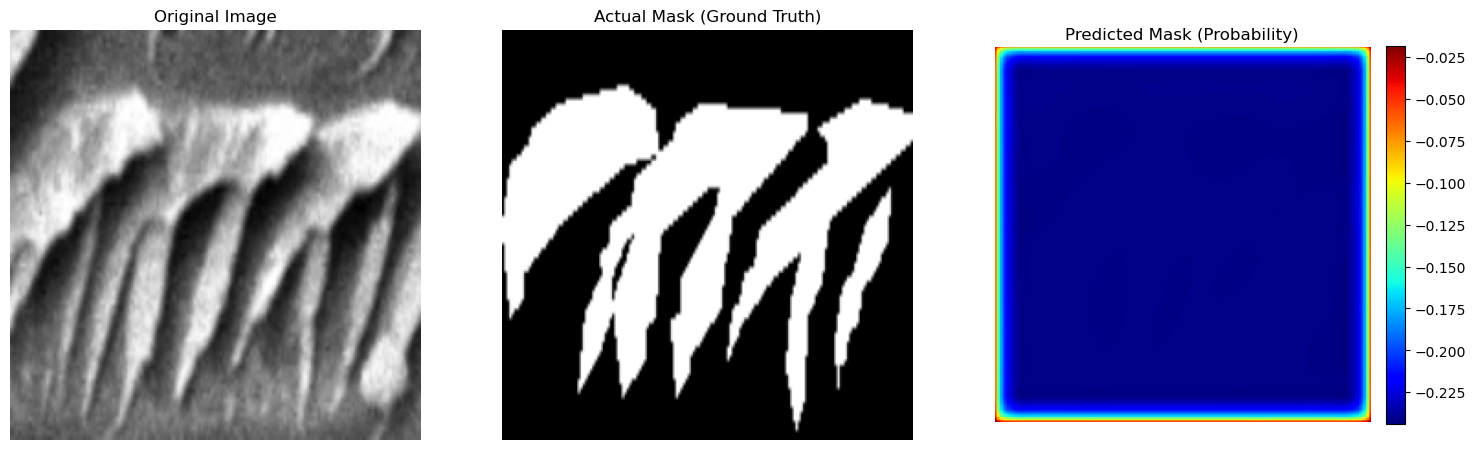

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


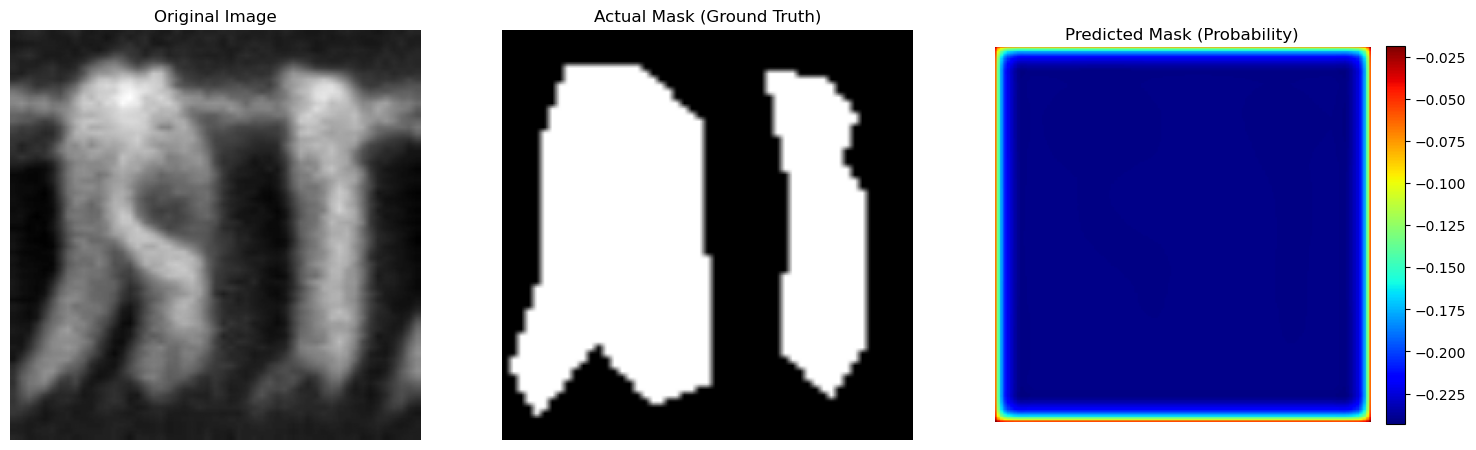

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


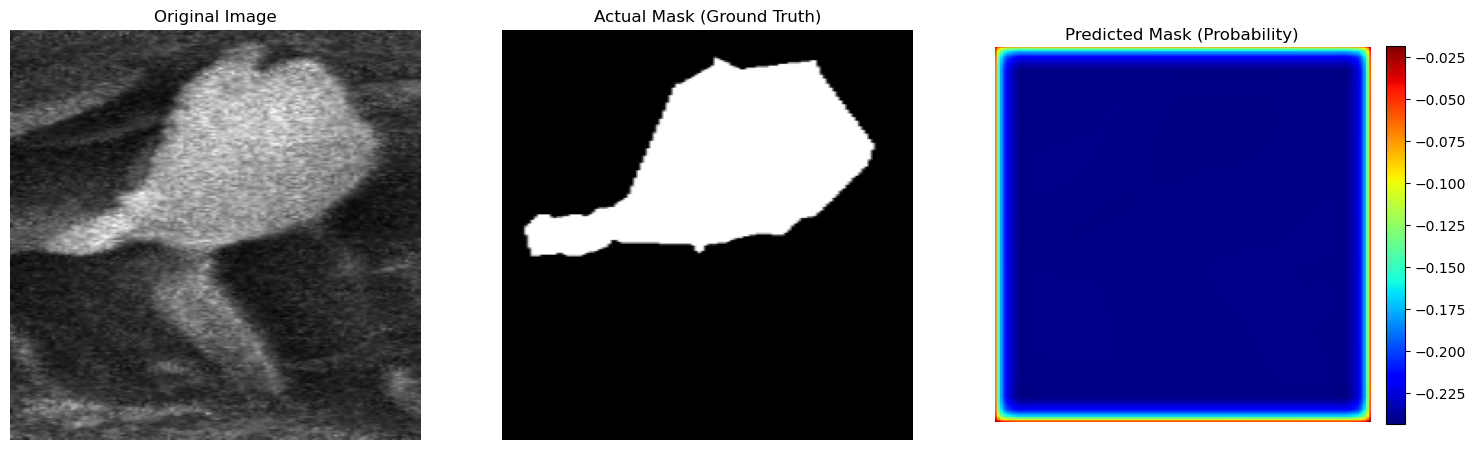

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


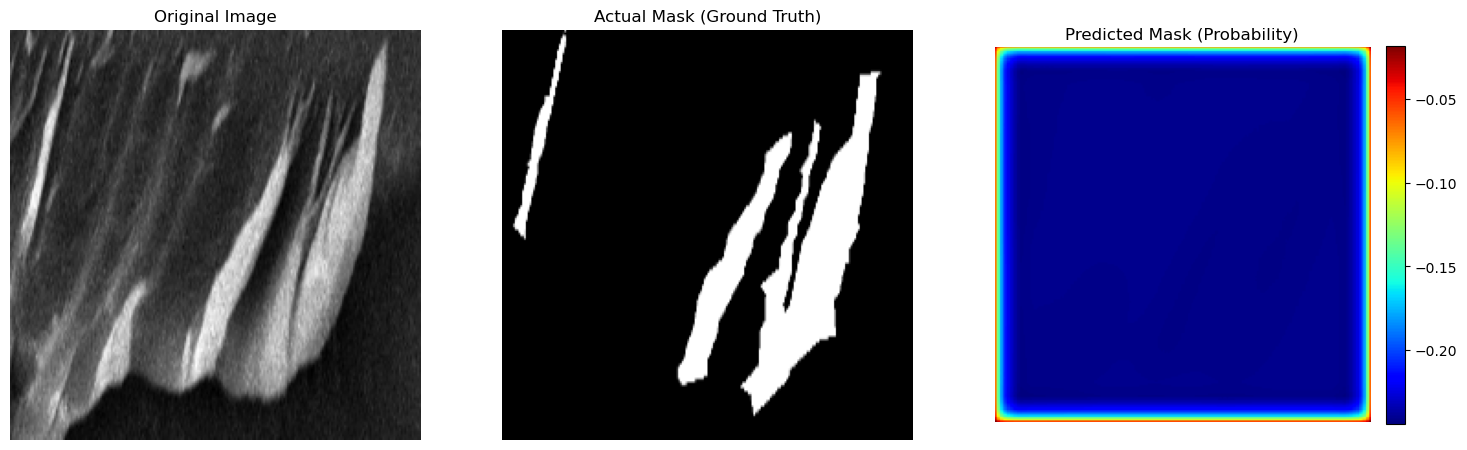

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


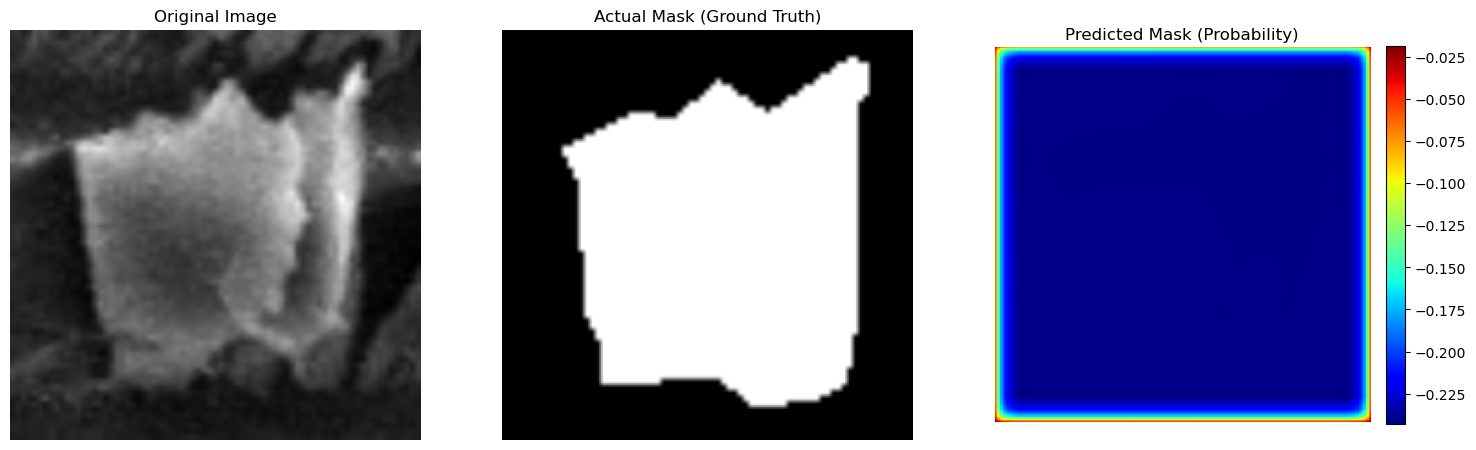

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


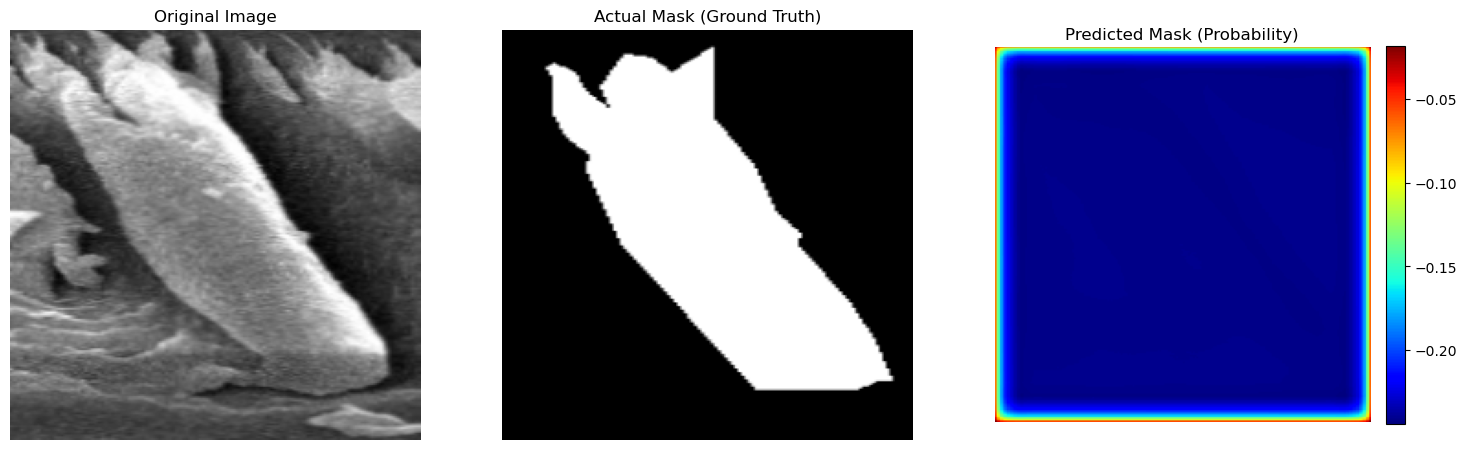

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


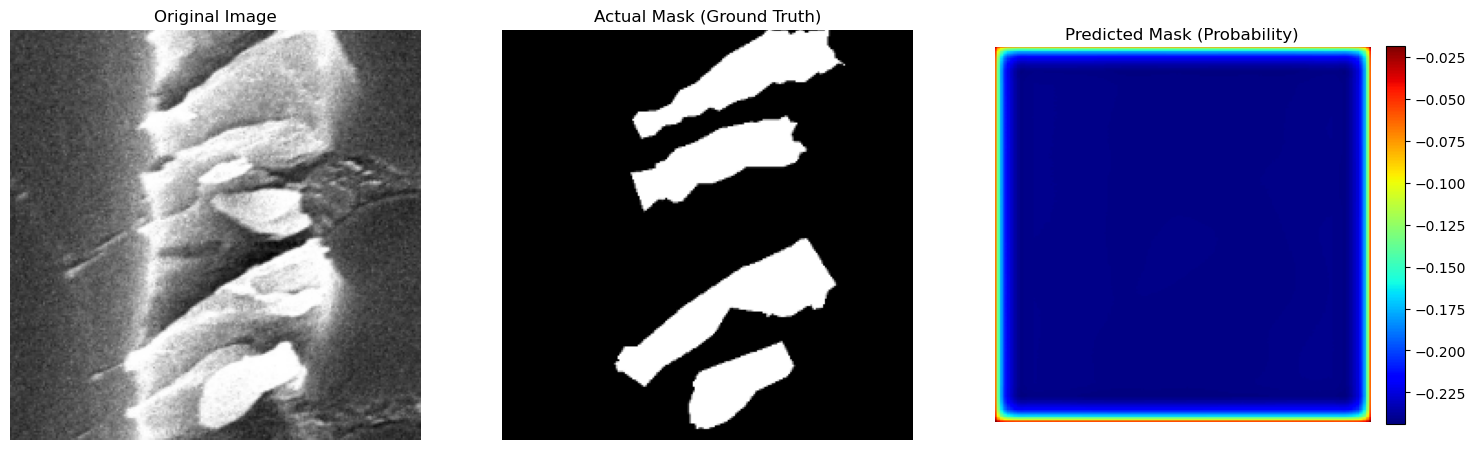

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


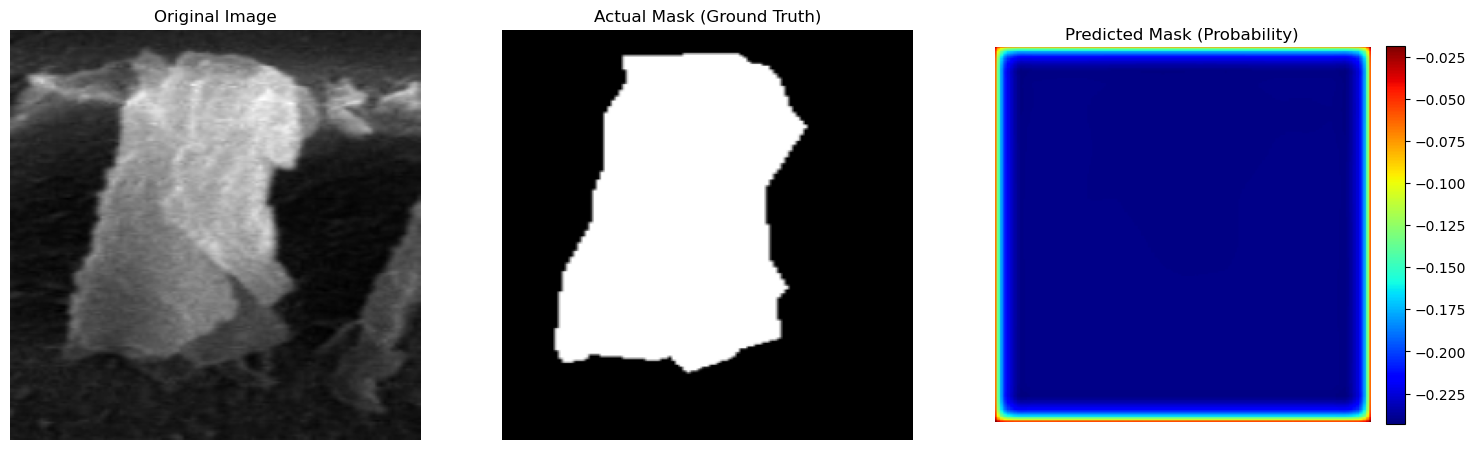

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


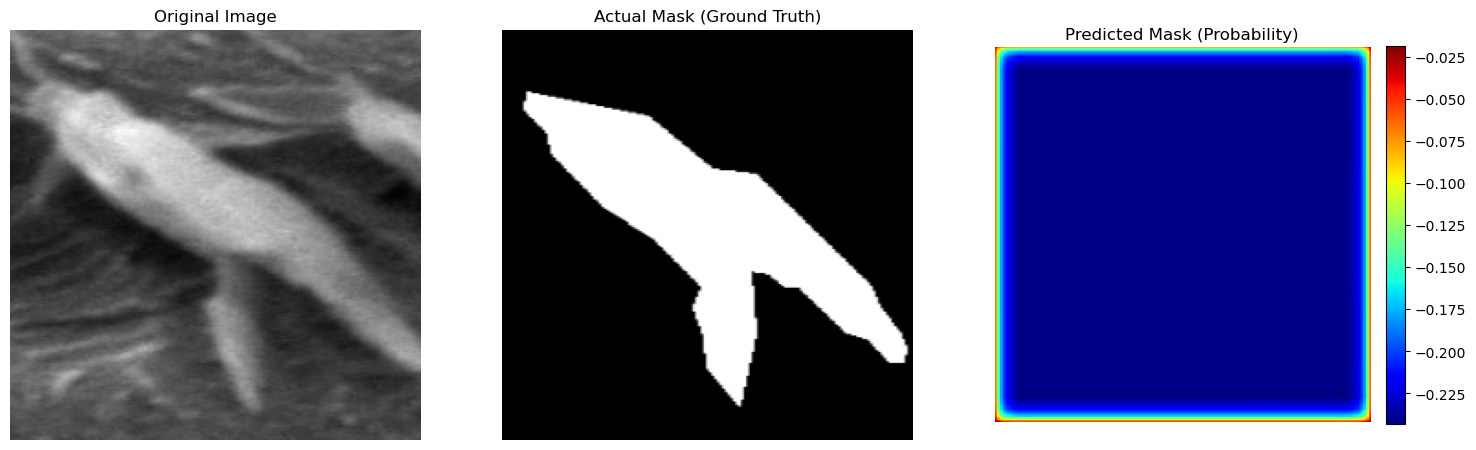

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


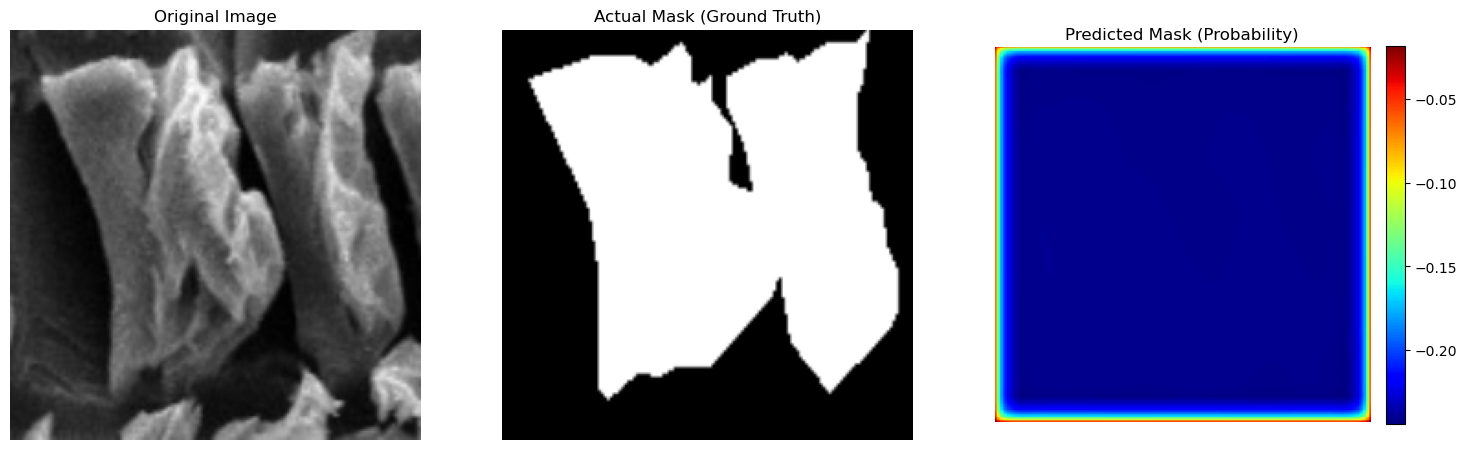

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


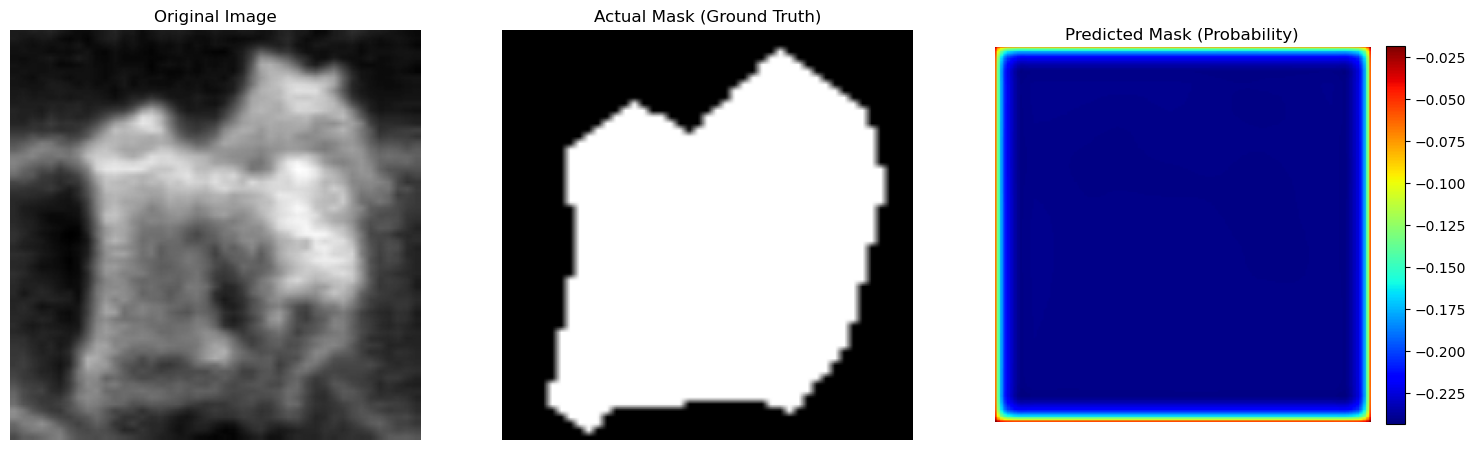

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


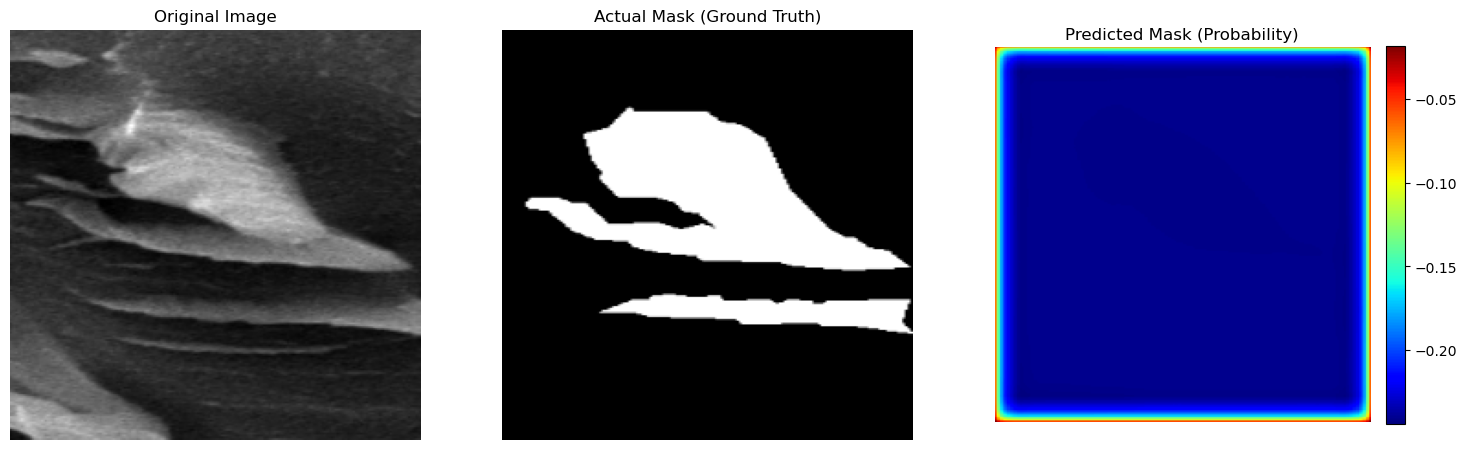

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


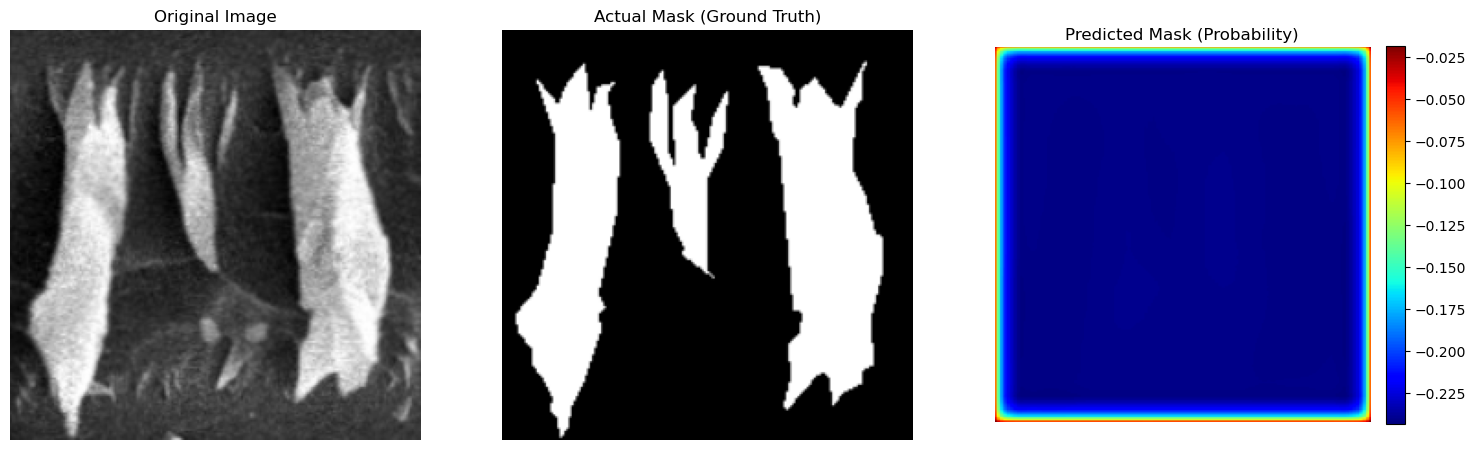

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


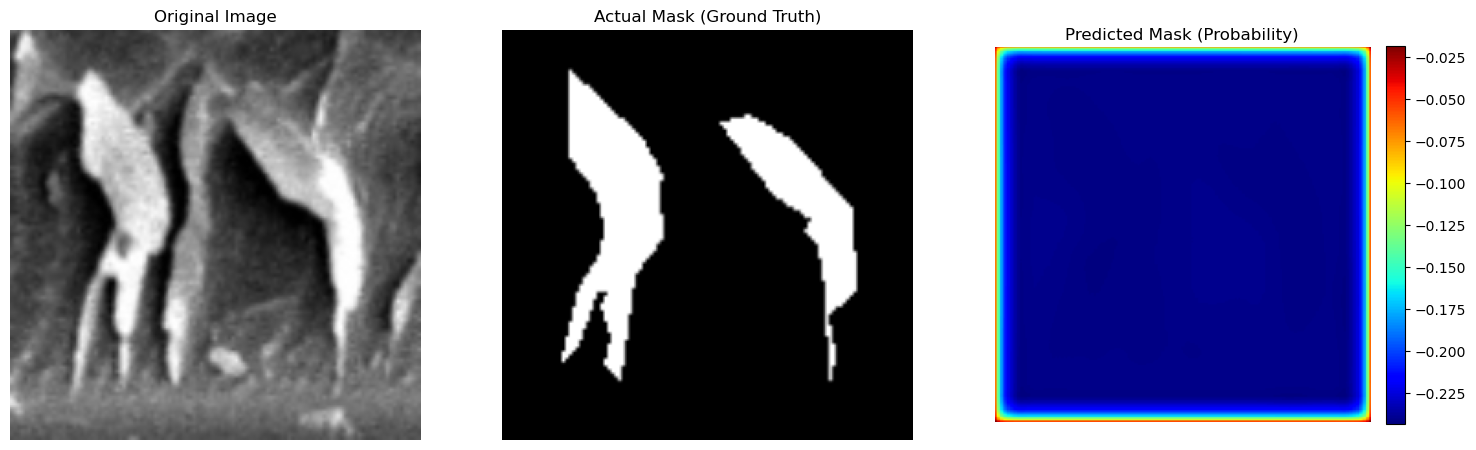

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


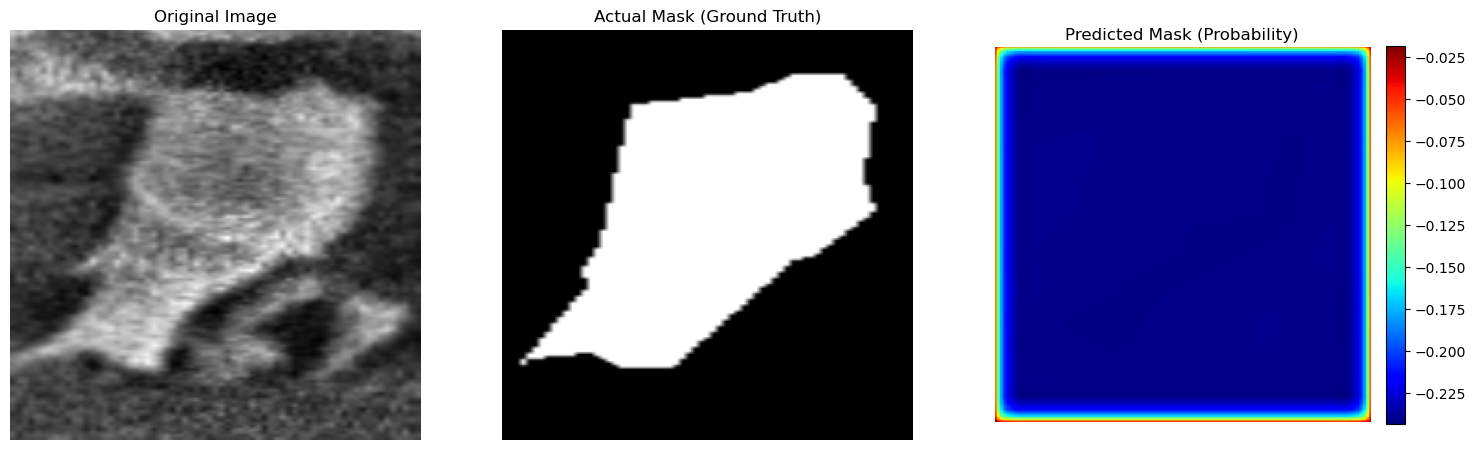

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


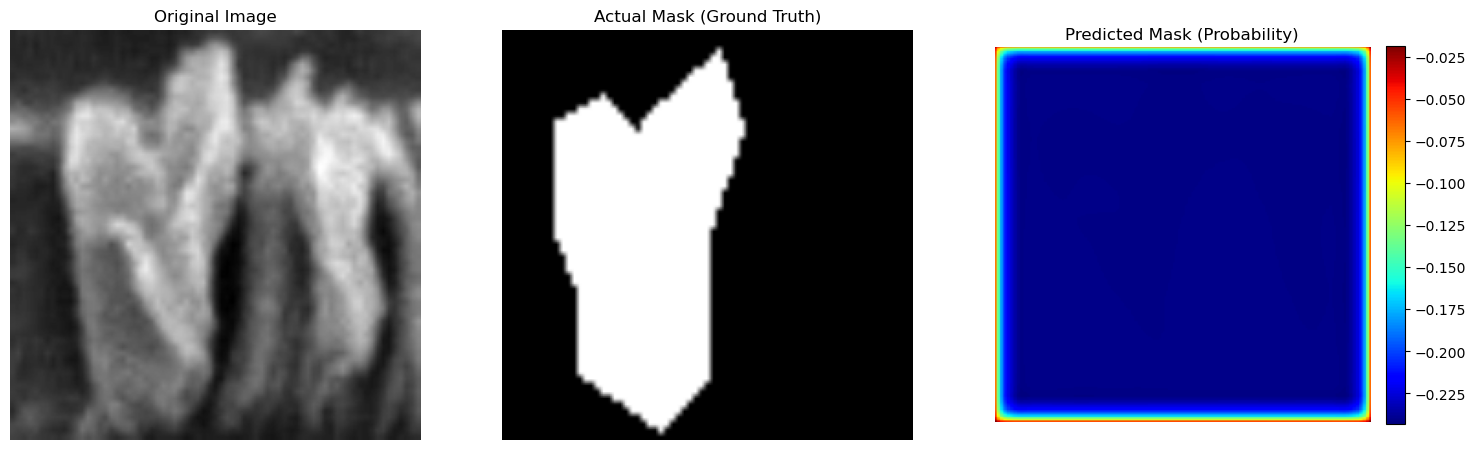

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


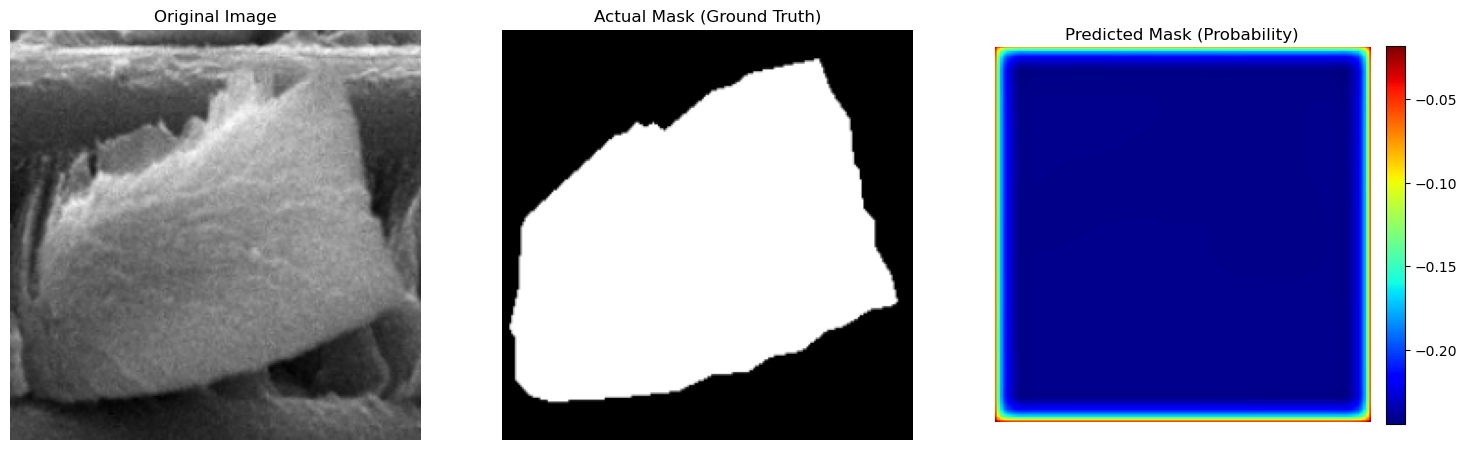

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


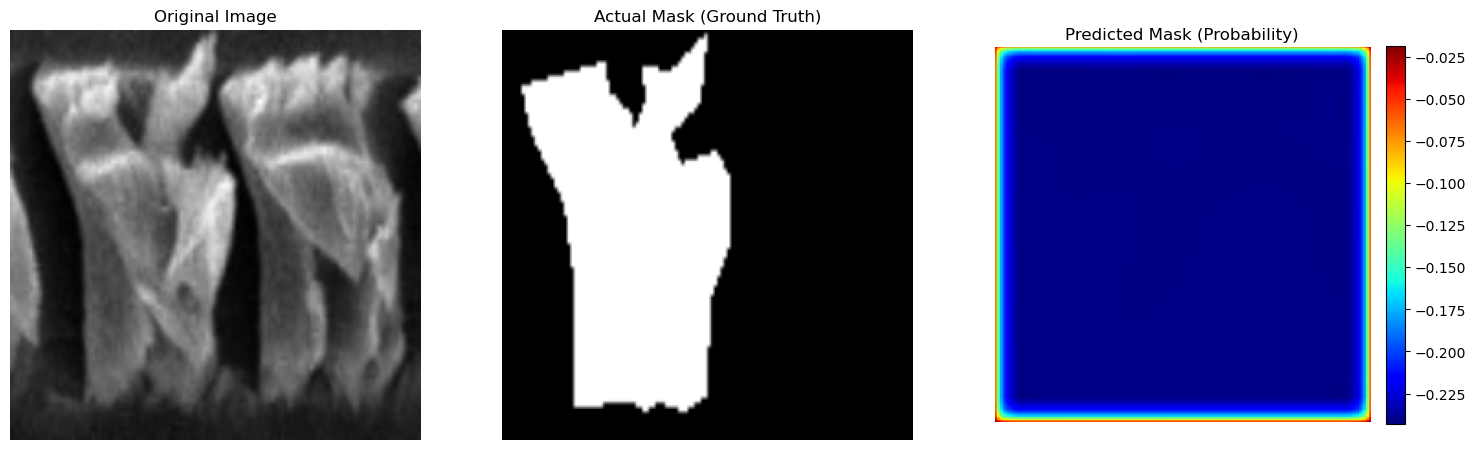

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


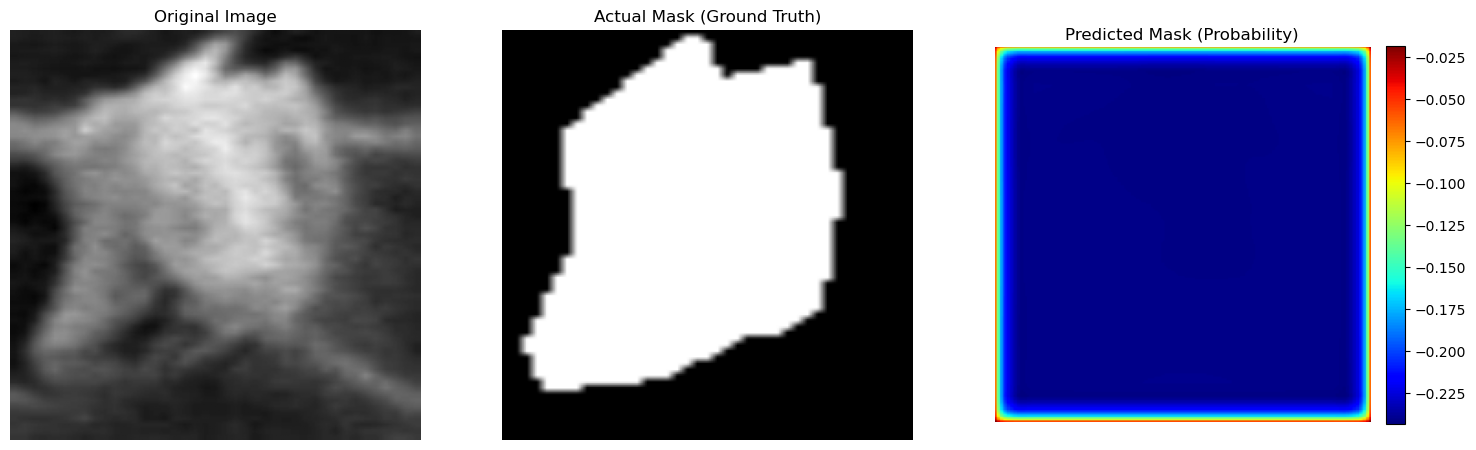

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


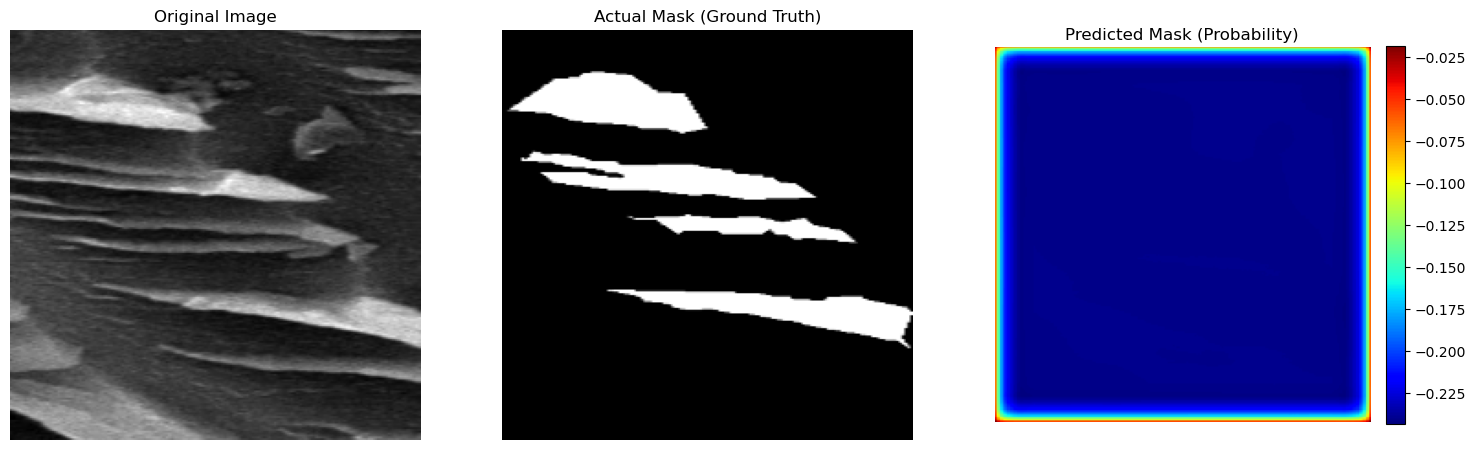

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


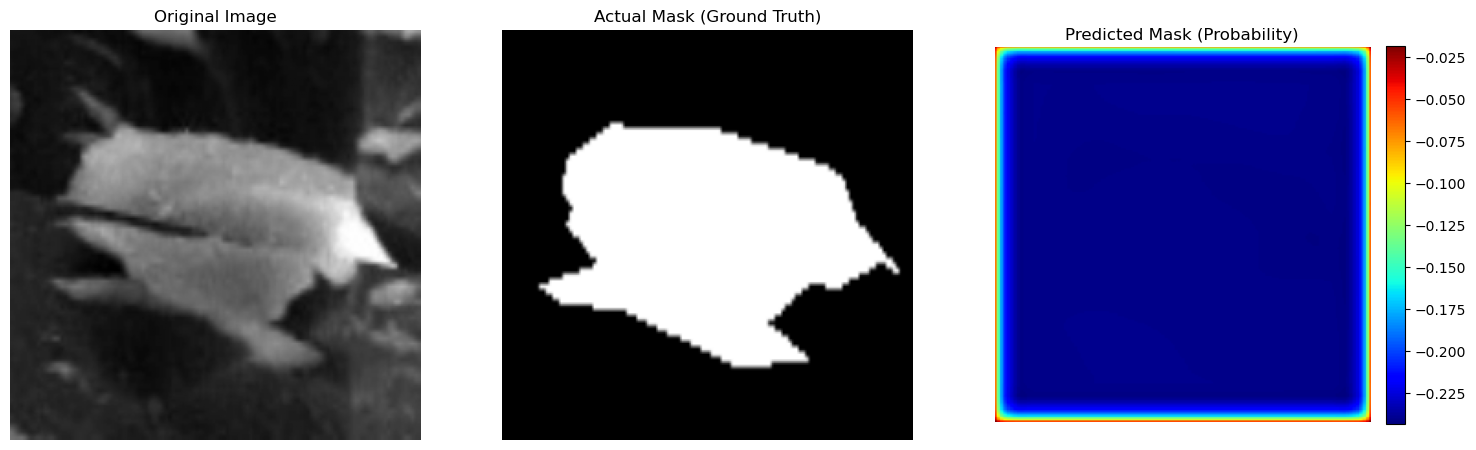

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


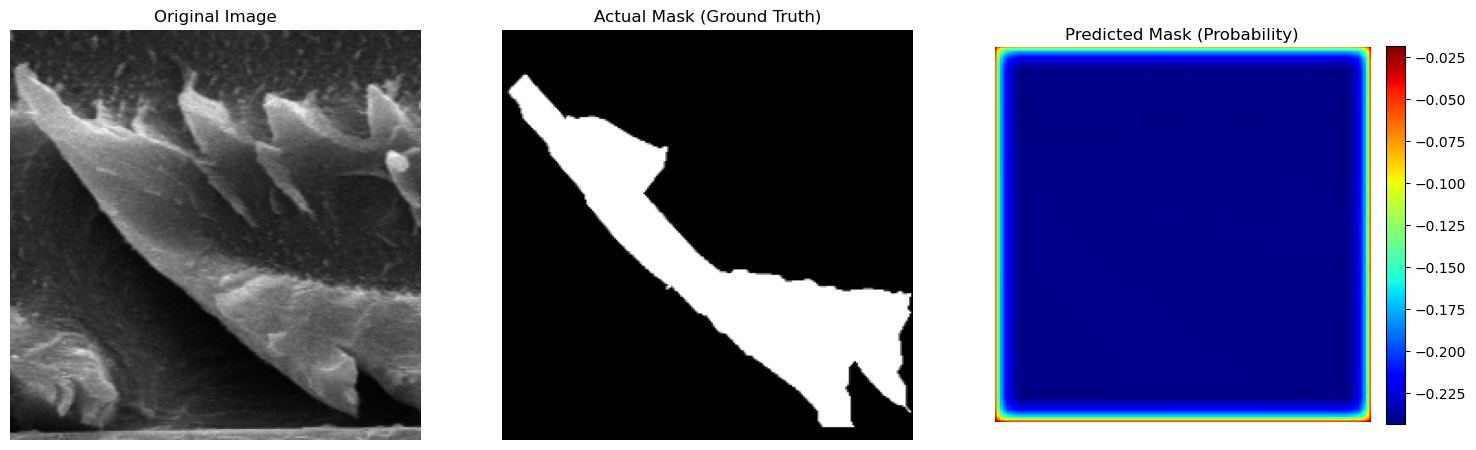

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


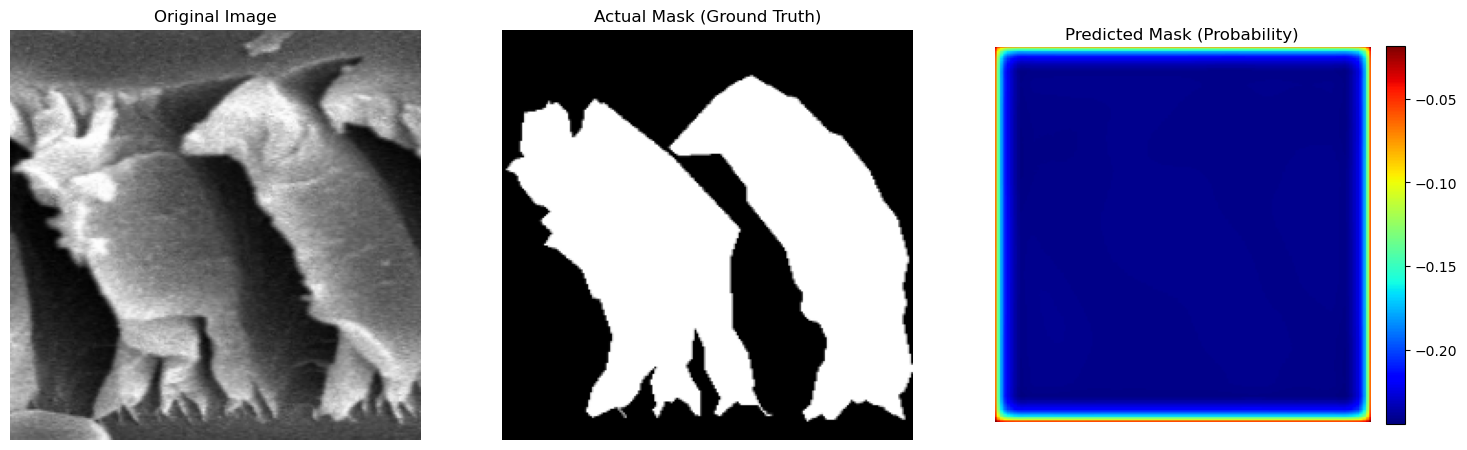

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


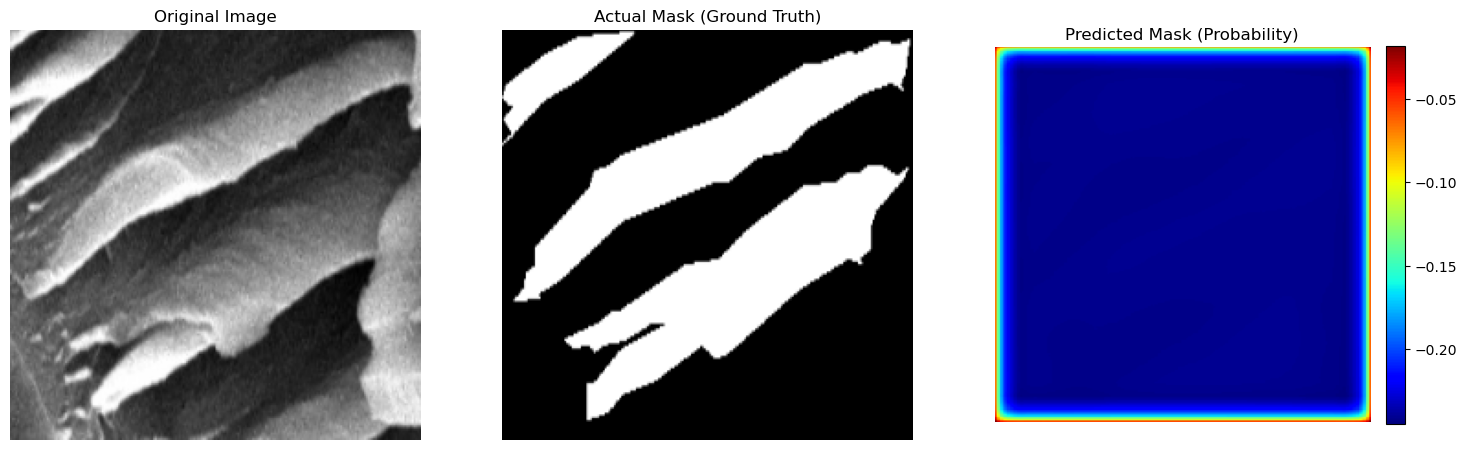

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


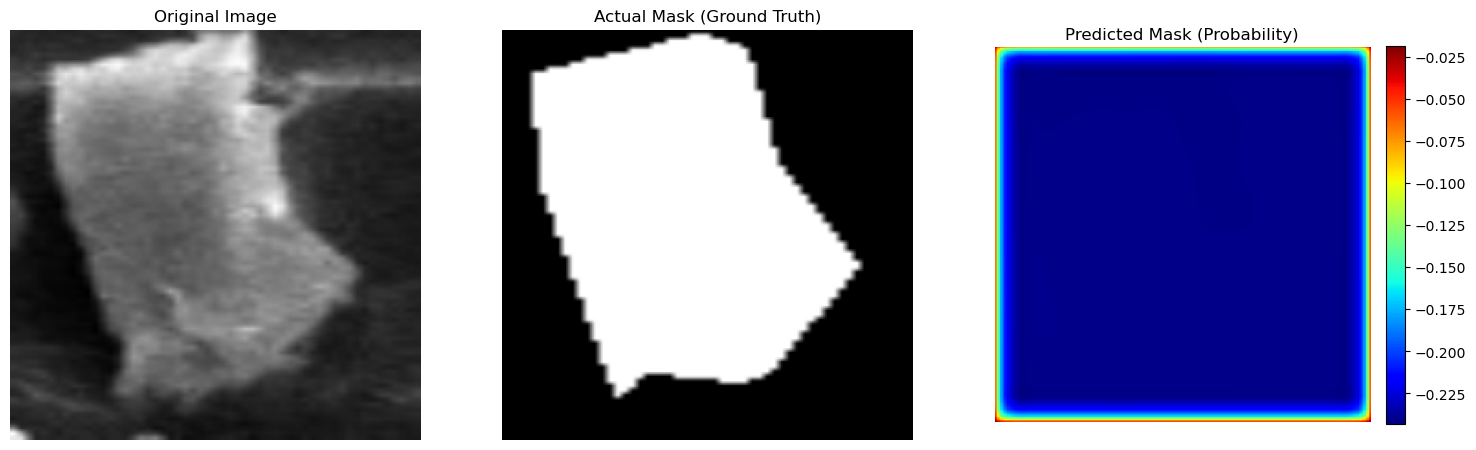

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


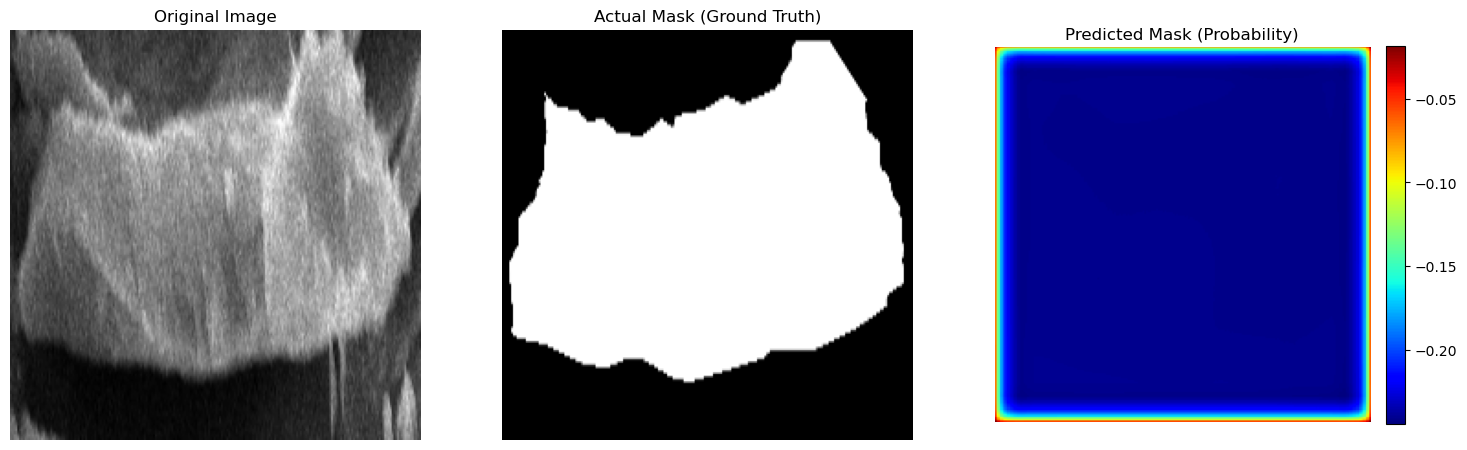

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


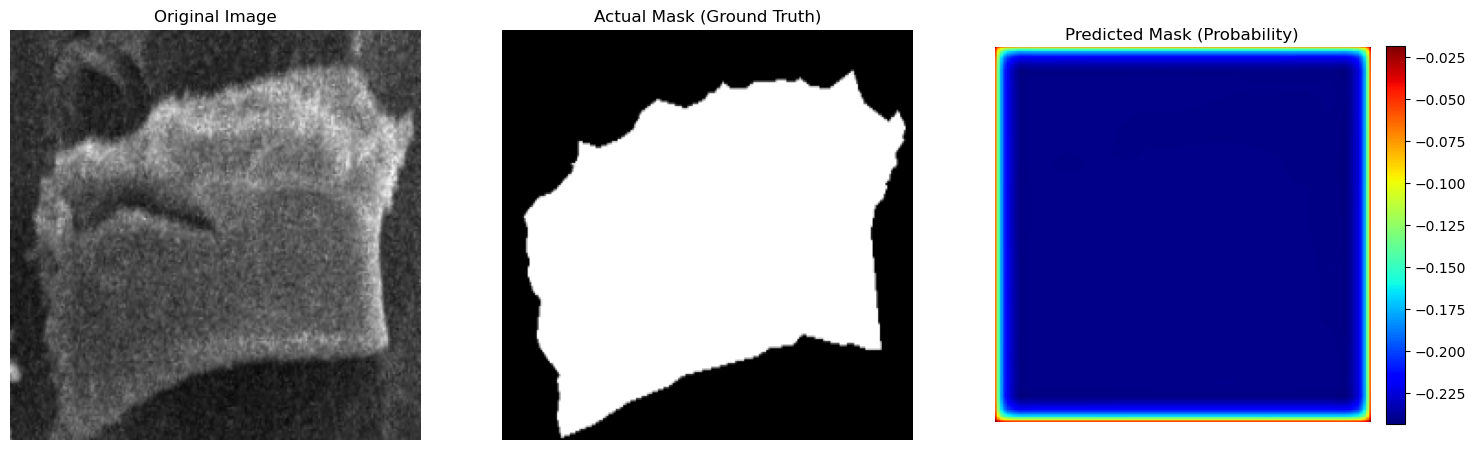

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


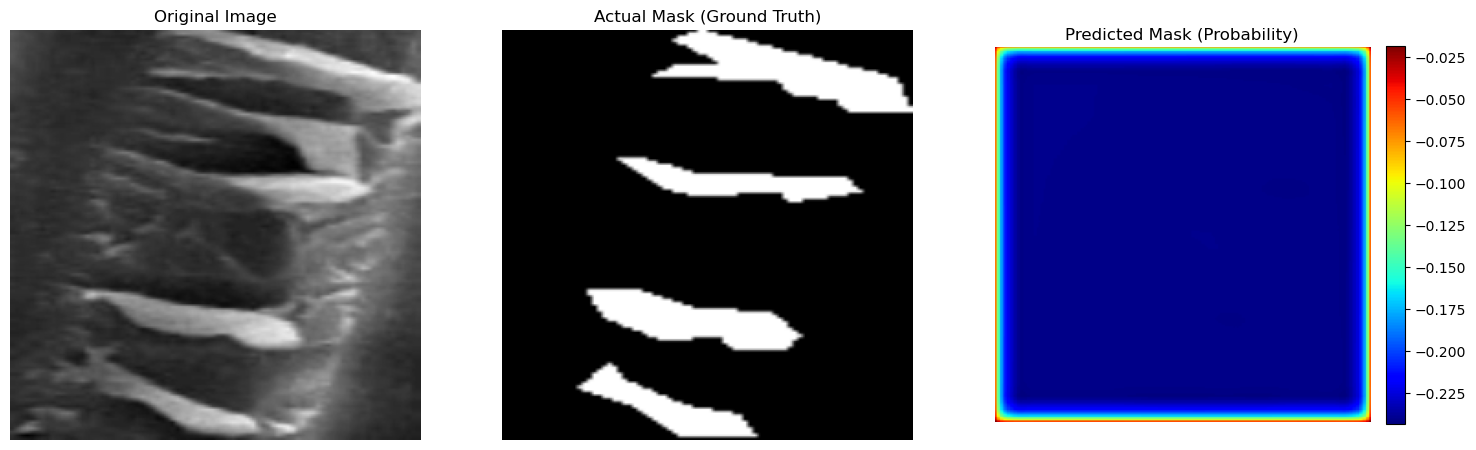

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


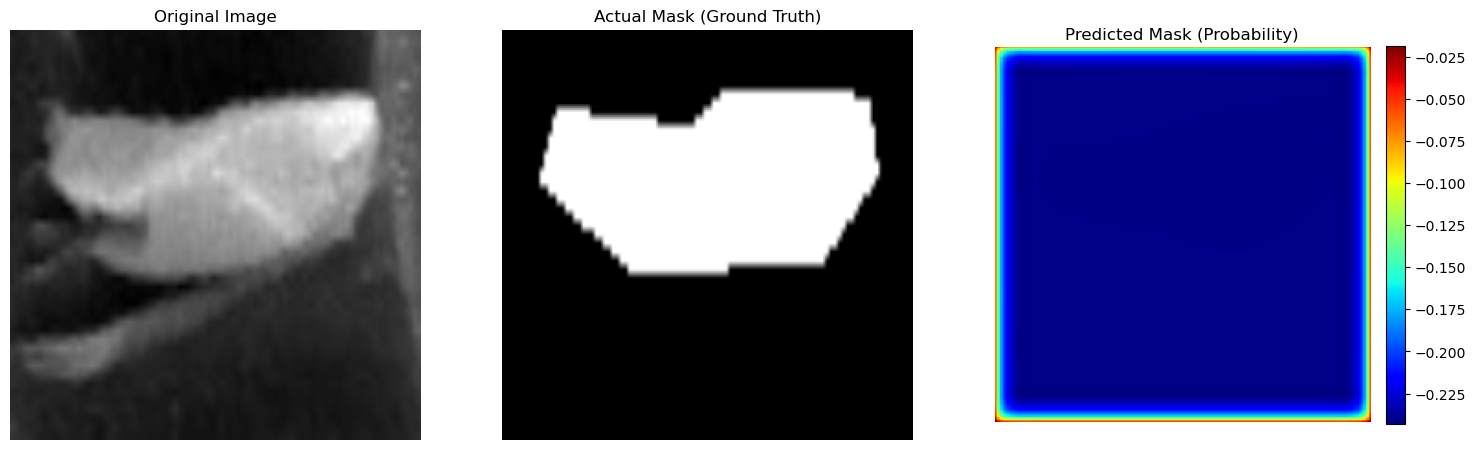

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


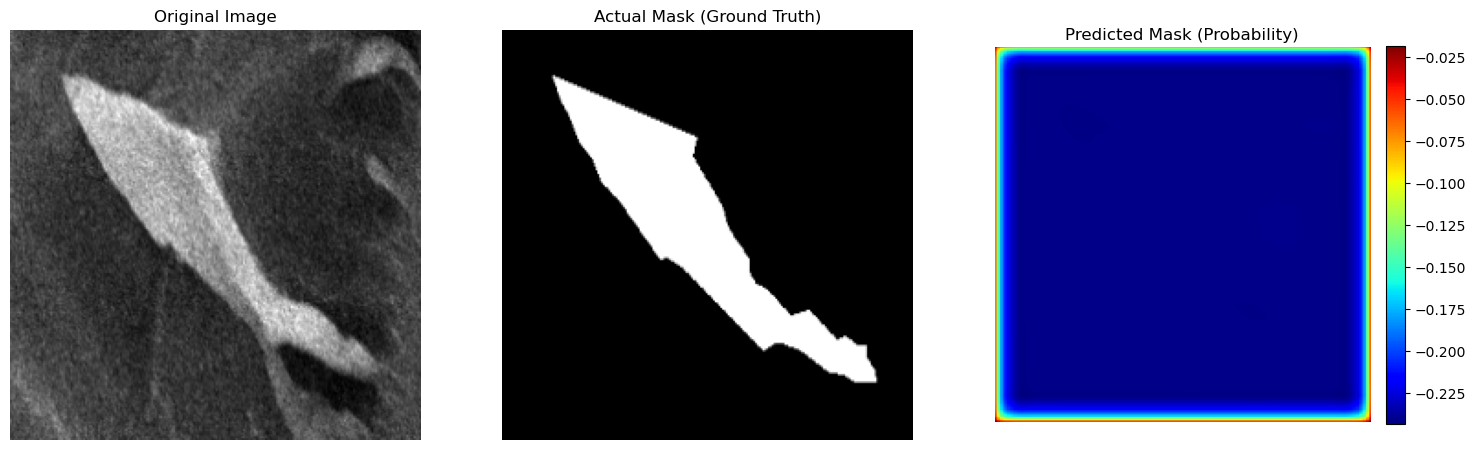

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


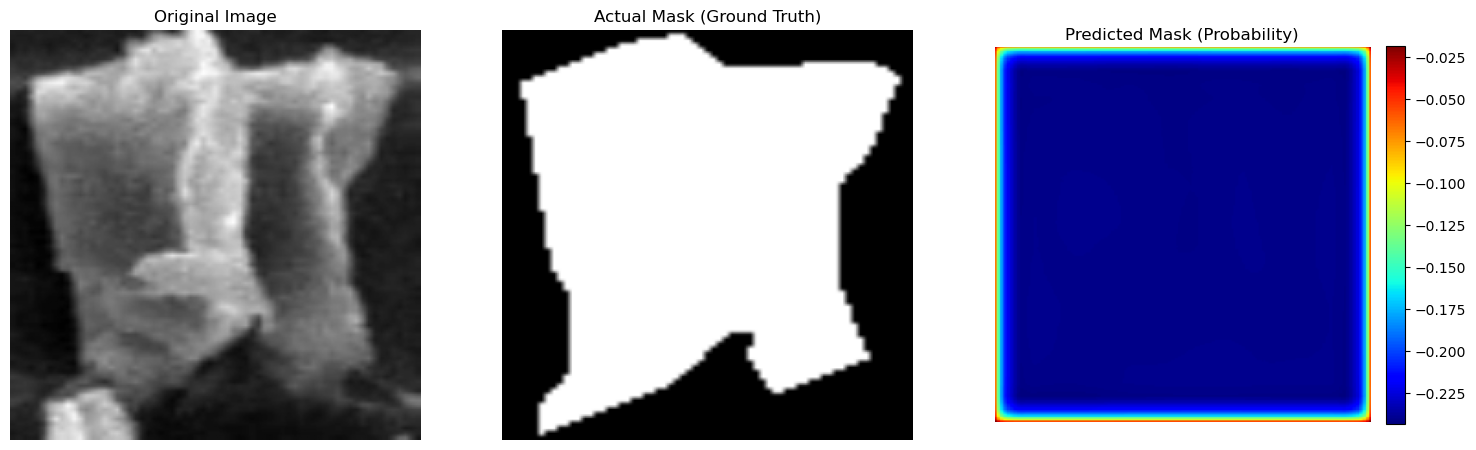

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


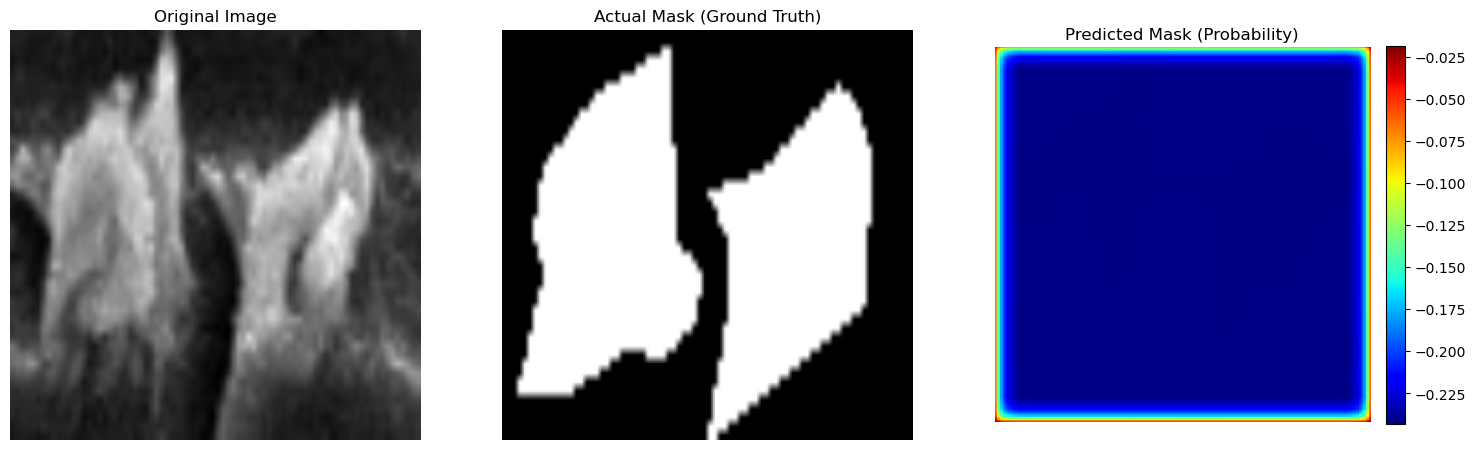

In [20]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def predict_mask(image, model, target_size=(224, 224)):
    """Resize image, predict mask, and resize mask back to original size."""
    original_size = image.shape[:2]
    
    # Normalize and add channel + batch dimensions
    resized_image = cv2.resize(image, target_size)
    resized_image = np.expand_dims(resized_image, axis=-1)  # Add channel dimension
    resized_image = np.expand_dims(resized_image, axis=0)   # Add batch dimension
    resized_image = resized_image.astype(np.float32) / 255.0
    
    # Predict mask
    predicted_mask = model.predict(resized_image)[0, :, :, 0]
    
    # Resize mask back to original image size
    predicted_mask = cv2.resize(predicted_mask, (original_size[1], original_size[0]))
    
    return predicted_mask

# ✅ Loop over test images
for i in range(len(X_test)):
    img = X_test[i].squeeze()  # Original image
    true_mask = y_test[i].squeeze()  # Ground truth mask

    # Predict mask
    predicted_mask = predict_mask(img, model)

    # 📌 Create subplot
    plt.figure(figsize=(18, 6))

    # 🔹 Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    # 🔹 Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title("Actual Mask (Ground Truth)")
    plt.axis("off")

    # 🔹 Predicted Mask with Probability Legend
    plt.subplot(1, 3, 3)
    mask_plot = plt.imshow(predicted_mask, cmap='jet')
    plt.colorbar(mask_plot, fraction=0.046, pad=0.04)  # ✅ Add colorbar legend
    plt.title("Predicted Mask (Probability)")
    plt.axis("off")

    plt.show()


In [ ]:
def load_test_images(filenames, image_dir, mask_dir):
    images, masks = [], []

    for filename in filenames:
        img_path = os.path.join(image_dir, filename)
        
        # ✅ Convert .jpg filename to .png for mask lookup
        mask_filename = os.path.splitext(filename)[0] + ".png"
        mask_path = os.path.join(mask_dir, mask_filename) if mask_filename in mask_filenames else None

        # Load image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Skipping {filename} (missing image)")
            continue

        # Resize image
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=-1)

        # Load mask or create an empty one
        if mask_path and os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
            mask = mask.astype(np.float32) / 255.0
            mask = np.expand_dims(mask, axis=-1)
        else:
            mask = np.zeros((IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load test images (no augmentation)
X_test, y_test = load_test_images(test_filenames, image_dir, mask_dir)

print(f"Final Test Set Size: {len(X_test)} images")


In [ ]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def predict_full_image_with_saliency_and_binary_mask(image, model, target_size=(224, 224), threshold=0.2):
    """Resize image, predict mask, generate saliency map, and create binary mask."""
    original_size = image.shape[:2]
    
    # Normalize and add channel + batch dimensions
    resized_image = cv2.resize(image, target_size)
    resized_image = np.expand_dims(resized_image, axis=-1)  # Add channel dimension
    resized_image = np.expand_dims(resized_image, axis=0)   # Add batch dimension
    resized_image = resized_image.astype(np.float32) / 255.0
    
    # Convert image to tensor
    image_tensor = tf.convert_to_tensor(resized_image)
    image_tensor = tf.Variable(image_tensor, dtype=tf.float32)
    
    # Perform model prediction
    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        prediction = model(image_tensor, training=False)
    
    # Compute the gradient of the prediction with respect to the image
    grads = tape.gradient(prediction, image_tensor)
    saliency_map = tf.reduce_max(tf.abs(grads), axis=-1).numpy().squeeze()
    
    # Resize the saliency map back to the original size
    saliency_map = cv2.resize(saliency_map, (original_size[1], original_size[0]))
    
    # Predict mask
    predicted_mask = prediction[0, :, :, 0].numpy()
    
    # Resize mask back to original image size
    predicted_mask = cv2.resize(predicted_mask, (original_size[1], original_size[0]))
    
    # Generate binary mask using threshold
    binary_mask = (predicted_mask > threshold).astype(np.float32)  # Apply threshold
    
    return predicted_mask, saliency_map, binary_mask

# ✅ Loop over test images and evaluate
y_true_all = []
y_pred_all = []

for i in range(len(X_test)):
    img = X_test[i]
    true_mask = y_test[i].squeeze()  # Ground truth mask

    # Predict mask & saliency
    predicted_mask, saliency_map, binary_mask = predict_full_image_with_saliency_and_binary_mask(img, model)

    # Store flattened true & predicted masks for PR curve
    y_true_all.extend(true_mask.flatten())
    y_pred_all.extend(predicted_mask.flatten())

    # 📌 Plot results
    plt.figure(figsize=(20, 5))
    
    # Original Image
    plt.subplot(1, 4, 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title("Original Image")
    plt.axis("off")
    
    # Image with Saliency
    plt.subplot(1, 4, 2)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.imshow(saliency_map, cmap='jet', alpha=0.5)
    plt.title("Image with Saliency")
    plt.axis("off")
    
    # Predicted Mask
    plt.subplot(1, 4, 3)
    plt.imshow(predicted_mask, cmap='jet')
    plt.title("Predicted Mask")
    plt.axis("off")
    
    # Binary Mask (Thresholded)
    plt.subplot(1, 4, 4)
    plt.imshow(binary_mask, cmap='gray')
    plt.title("Binary Mask (Thresholded)")
    plt.axis("off")
    
    plt.show()




In [ ]:
print("Unique values in test masks:", np.unique(y_test))


In [ ]:
# ✅ Precision-Recall Curve
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

precision, recall, _ = precision_recall_curve(y_true_all, y_pred_all)
ap_score = average_precision_score(y_true_all, y_pred_all)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label=f'AP = {ap_score:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

print(f"🔹 Average Precision Score: {ap_score:.4f}")

The next section slides across a larger image, the window size makes a difference in masks produced

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
windowsize = 448
def slide_window(image, window_size=(windowsize, windowsize), step_size=windowsize/2):
    patches = []
    h, w = image.shape
    window_height, window_width = window_size
    
    for i in range(0, h - window_height + 1, step_size):  # Sliding with step_size
        for j in range(0, w - window_width + 1, step_size):
            patch = image[i:i + window_height, j:j + window_width]
            patches.append((patch, (i, j)))  # Store patch and its top-left position
    
    return patches

large_image = cv2.imread("/Users/rfalcao/Documents/FYP/ClearCuspsCroppedRotated/1.tif", cv2.IMREAD_GRAYSCALE)
large_image = large_image[:int(large_image.shape[0] * 0.7), int(large_image.shape[1] * 0.5):]
patches = slide_window(large_image, window_size=(windowsize, windowsize), step_size=112)

for idx, (patch, (start_row, start_col)) in enumerate(patches[:10]):  # Limit to first 10 patches for display
    if patch is None:
        continue
    
    predicted_mask, saliency_map, binary_mask = predict_full_image_with_saliency_and_binary_mask(patch, model)
    
    # Create the plots
    plt.figure(figsize=(20, 5))
    
   
    plt.subplot(1, 4, 1)
    plt.imshow(large_image, cmap='gray')
    rect = plt.Rectangle((start_col, start_row), windowsize, windowsize, linewidth=2, edgecolor='r', facecolor='none')  # Mark window position
    plt.gca().add_patch(rect)
    plt.title("Original Image with Window Position")
    plt.axis("off")
    
    plt.subplot(1, 4, 2)
    plt.imshow(patch, cmap='gray')
    plt.imshow(saliency_map, cmap='jet', alpha=0.5)  # Saliency overlay with transparency
    plt.title("Image with Saliency")
    plt.axis("off")
    
    # Plot predicted mask
    plt.subplot(1, 4, 3)
    plt.imshow(predicted_mask, cmap='jet')
    plt.title("Predicted Mask")
    plt.axis("off")
    
    # Plot binary mask
    plt.subplot(1, 4, 4)
    plt.imshow(binary_mask, cmap='gray')
    plt.title("Binary Mask (Thresholded)")
    plt.axis("off")
    
    plt.show()
